In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
from astropy.io import fits
from scipy.interpolate import interp1d
from scipy.stats import ks_2samp, norm, anderson_ksamp

In [13]:
def read_in_completeness_period(inputgrid, verbose=False):
    hdulist = fits.open(inputgrid)
    cumulative_array = hdulist[0].data
    kiclist = np.asarray(hdulist[1].data, dtype=np.int32)
    probdet = np.transpose(cumulative_array[0])
    probtot = np.transpose(cumulative_array[1])
    prihdr = hdulist[0].header
    min_comp_period = prihdr["MINPER"]
    max_comp_period = prihdr["MAXPER"]
    n_comp_period = prihdr["NPER"]
    min_comp_rp = prihdr["MINRP"]
    max_comp_rp = prihdr["MAXRP"]
    n_comp_rp = prihdr["NRP"]
    hdulist.close()
    rp_want = np.linspace(min_comp_rp, max_comp_rp, n_comp_rp)
    period_want = np.linspace(min_comp_period, max_comp_period, n_comp_period)
    period_want2d, rp_want2d = np.meshgrid(period_want, rp_want, indexing='ij')
    numCompVeInterp = RectBivariateSpline(period_want, rp_want, probtot)
    if verbose:
        print(f"Min Period: {min_comp_period}\nMax Period: \
            {max_comp_period}\nSize:{n_comp_period}")
        print(f"Min Radius: {min_comp_rp}\nMax Radius: \
            {max_comp_rp}\nSize:{n_comp_rp}")
    return(numCompVeInterp, kiclist, probtot, probdet, probdet/probtot)

Min Period: 1.0
Max Period:             100.0
Size:2001
Min Radius: 0.5
Max Radius:             10.0
Size:3001


/Users/ksullivan/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


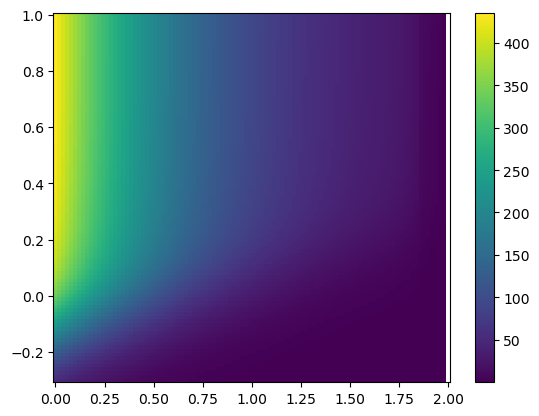

In [14]:
numCompVeInterp_FGK, kiclist_FGK, probtot, probdet, ratio = read_in_completeness_period(\
                                                               "../completenessContours/out_sc0_GK_baseline_140.fits.gz",\
                                                               verbose=True)

x = np.linspace(np.log10(1), np.log10(100), num=100)
y = np.linspace(np.log10(0.5), np.log10(10), num=100)
xg, yg = np.meshgrid(x, y, indexing='ij')


summedCompleteness = numCompVeInterp_FGK(10**x, 10**y)
summedCompleteness[np.where(summedCompleteness <= 0)] = np.nan
plt.figure()
plt.pcolormesh(xg, yg, summedCompleteness)
plt.colorbar()
plt.show()

# probtot[-1], probdet[-1], ratio[-1]

In [17]:
x = np.linspace(np.log10(1), np.log10(100), num=501)
y = np.linspace(np.log10(0.5), np.log10(10), num=501)

In [18]:
comp = np.array([np.load('complete/completeness_{}.npy'.format(n)) for n in range(500)])
complete = np.nanmean(comp, axis = 0)

observations = np.array([np.load('obs/obs_kde_{}_10.npy'.format(n)) for n in range(500)])
obs = np.nanmean(observations, axis = 0)

for n, c in enumerate(comp):
    comp[n][np.where(c <= 1e-5)] = 1000

occurrence = [observations[n]/comp[n] for n in range(500)]

occ = np.nanmean(occurrence, axis = 0)
occ_err = np.nanstd(occurrence, axis = 0)
# occ_subset = np.array(occurrence)[np.random.choice(range(len(occurrence)), size = 100, replace = False)]

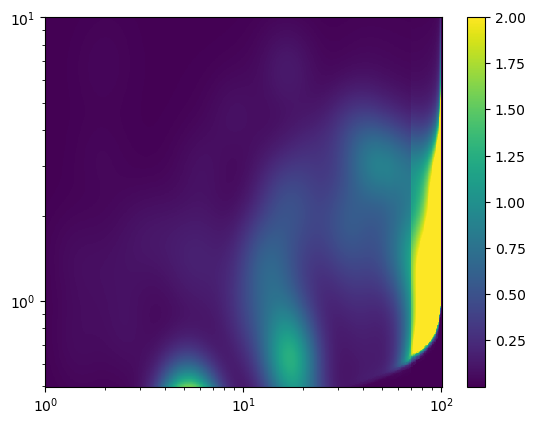

In [19]:
xg, yg = np.meshgrid(x, y)

a = plt.pcolormesh(10**(xg), 10**(yg), occ.T, vmax = 2)
plt.colorbar()
plt.xscale('log')
plt.yscale('log')


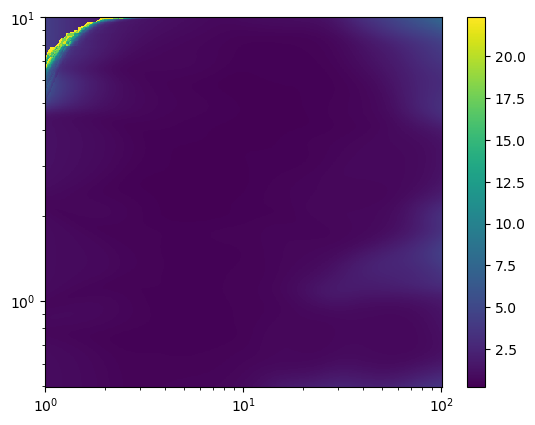

In [20]:
a = plt.pcolormesh(10**(xg), 10**(yg), occ_err/occ)
plt.colorbar()
plt.xscale('log')
plt.yscale('log')

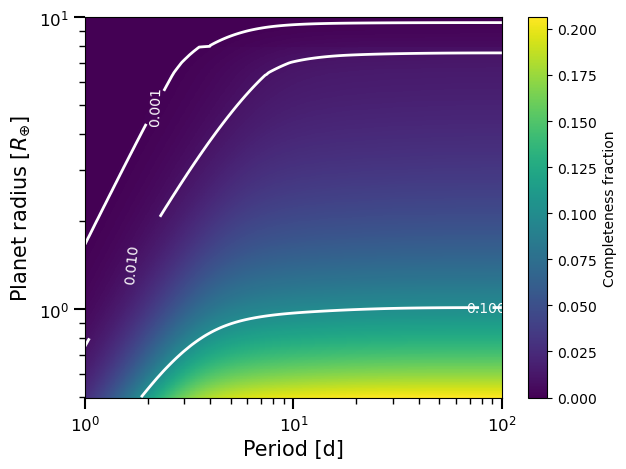

In [21]:
fig, ax = plt.subplots()
a = ax.pcolormesh(10**xg, 10**yg, complete, rasterized = True)
b = plt.colorbar(a, label = 'Completeness fraction')
contour = ax.contour(10**xg, 10**yg, complete, levels = np.array([1e-3, 0.01, 0.1]), linewidths = 2, colors = 'w')
ax.clabel(contour, fontsize=10)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Period [d]', fontsize = 15)
ax.set_ylabel(r'Planet radius [$R_{\oplus}$]', fontsize = 15)
plt.minorticks_on()
plt.tick_params(which='minor', bottom=True, top =False, left=True, right=False)
plt.tick_params(bottom=True, top =False, left=True, right=False)
plt.tick_params(which='both', labelsize = "large", direction='out')
plt.tick_params('both', length=8, width=1.5, which='major')
plt.tick_params('both', length=4, width=1, which='minor')
plt.tight_layout()
plt.savefig('completeness_contour.pdf', dpi = 400)

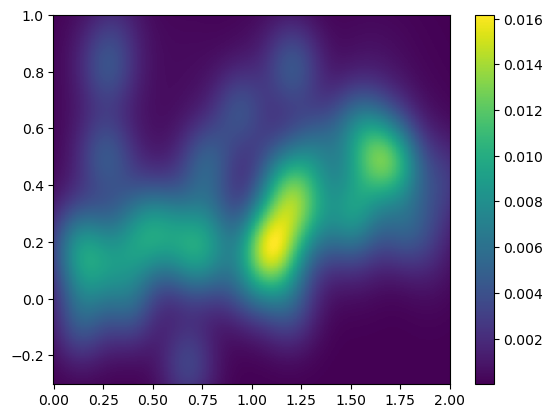

In [22]:
plt.pcolormesh(xg, yg, obs.T)
plt.colorbar()

## Make nice occurrence rate plot

In [23]:
# import all the libraries
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
import sys
from matplotlib.ticker import FormatStrFormatter

import matplotlib

In [24]:
x = np.linspace(np.log10(1), np.log10(100), num=501)
y = np.linspace(np.log10(0.5), np.log10(10), num=501)
xg, yg = np.meshgrid(x, y, indexing='ij')

In [25]:
# small grid for plotting
mr = np.logspace(np.log10(0.5), np.log10(10), num=9)
mp = np.logspace(np.log10(1.), np.log10(100), num=8)
mp_grid, mr_grid = np.meshgrid(mp, mr, indexing='ij')

mp_c = 0.5*(mp[1:] + mp[:-1])
mr_c = 0.5*(mr[1:] + mr[:-1])

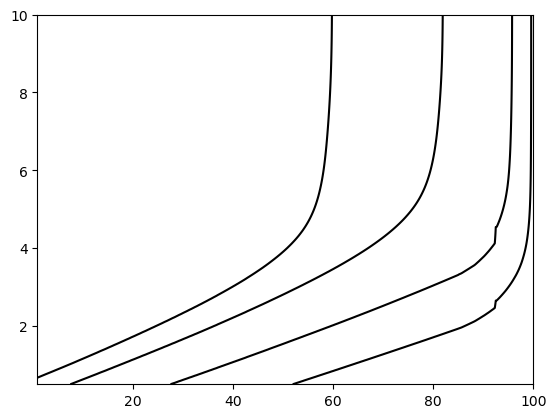

In [26]:
# set low-completeness limits
limit = np.array([1., 10., 50., 100.])
xl = np.linspace(1.0, 100., num=501)
yl = np.linspace(0.5, 10., num=501)
xlg, ylg = np.meshgrid(xl, yl, indexing='ij')
cs = plt.contour(xlg, ylg, complete, levels=limit/3000, colors='k')
xlim_FGK = cs.collections[2].get_paths()[0].vertices[:, 0]
ylim_FGK = cs.collections[2].get_paths()[0].vertices[:, 1]
# plt.close()
plt.show()

In [27]:
# for later (:
def kde_anywhere(Z, pmin, pmax, rmin, rmax):
    pmask = (np.where((x >= np.log10(pmin)) & (x <= np.log10(pmax)))[0][0], 
            np.where((x >= np.log10(pmin)) & (x <= np.log10(pmax)))[0][-1])
    rmask = (np.where((y >= np.log10(rmin)) & (y <= np.log10(rmax)))[0][0], 
            np.where((y >= np.log10(rmin)) & (y <= np.log10(rmax)))[0][-1])
    return(Z[pmask[0]:pmask[1]+1, rmask[0]:rmask[1]+1])

In [28]:
'''
add some weighting scheme for the catalogs?
'''
pcCatalog = np.array(["koiCatalogs/dr25_GK_KOIs_{}.csv".format(n) for n in range(500)])

pcCatalog_FGK = pd.read_csv(pcCatalog[0])

for n in range(1, 500):
    pcat = pd.read_csv(pcCatalog[n])
    pcCatalog_FGK = pd.merge(pcCatalog_FGK, pcat, how='outer')
    if n%50 == 0:
        print('adding', n)

# load in planet candidates
base_kois = pcCatalog_FGK.copy() #pd.read_csv(pcCatalog)
m = (1 <= base_kois.koi_period) & (base_kois.koi_period <= 100)
m &= np.isfinite(base_kois.corrected_prad) & (0.5 <= base_kois.corrected_prad) & (base_kois.corrected_prad <= 10)
#     
kois_FGK = pd.DataFrame(base_kois)

# create 2D histogram
H_FGK, xedges, yedges = np.histogram2d(kois_FGK.koi_period, kois_FGK.corrected_prad, bins=(mp, mr))
H_nan_FGK = H_FGK * 1
H_nan_FGK[H_nan_FGK < 1] = np.nan

# H_FGK = H_FGK.T

# this sets up where the low completeness limit is
H_lim_FGK = np.zeros(H_FGK.shape)
for i in range(len(xedges)-1):
    for j in range(len(yedges)-1):
        try:
            lim = ylim_FGK[np.where(xlim_FGK <= xedges[i])][0] > yedges[j]
        except:
            lim = False
        if np.all(lim):
            H_lim_FGK[i, j] = True
        else: 
            H_lim_FGK[i, j] = False
            

adding 50
adding 100
adding 150
adding 200
adding 250
adding 300
adding 350
adding 400
adding 450


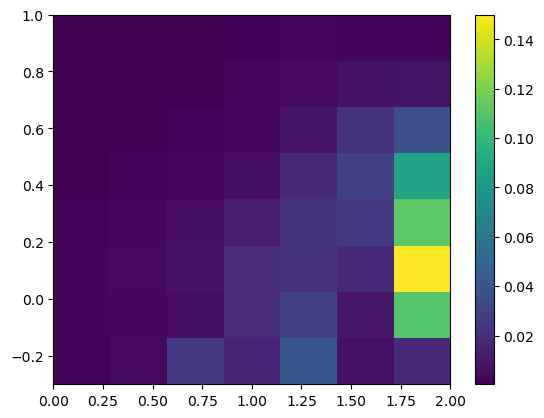

In [29]:
# boot_kde_FGK, boot_kde_err_FGK = np.load("out0827_FGK_sboot_1000__avg.npy")
boot_kde_smol_FGK = np.zeros((len(mp)-1, len(mr)-1))
boot_kde_smol_err_FGK = np.zeros((len(mp)-1, len(mr)-1))
# boot_kde_err_FGK = occ_err
# print(boot_kde_err_FGK)
# go forth and propagate

for i in range(len(mp)-1):
    for j in range(len(mr)-1):
        z = kde_anywhere(occ, mp[i], mp[i+1], mr[j], mr[j+1])
        boot_kde_smol_FGK[i, j] = np.sum(z)*(np.diff(x)[0]*np.diff(y)[0])
        z_e = np.sum(kde_anywhere(occ_err, mp[i], mp[i+1], mr[j], mr[j+1]))/np.sum(
                    kde_anywhere(occ, mp[i], mp[i+1], mr[j], mr[j+1]))
        
        boot_kde_smol_err_FGK[i, j] = np.sqrt(z_e**2)*boot_kde_smol_FGK[i, j]

# we don't want to plot cells that had no planet detections ! 
boot_kde_smol_FGK_nan = boot_kde_smol_FGK.copy()
boot_kde_smol_FGK_nan[H_FGK < 1] = np.nan
boot_kde_smol_FGK_nan[H_lim_FGK >= 1] = np.nan

plt.pcolormesh(np.log10(mp_grid), np.log10(mr_grid), boot_kde_smol_FGK)
plt.colorbar()

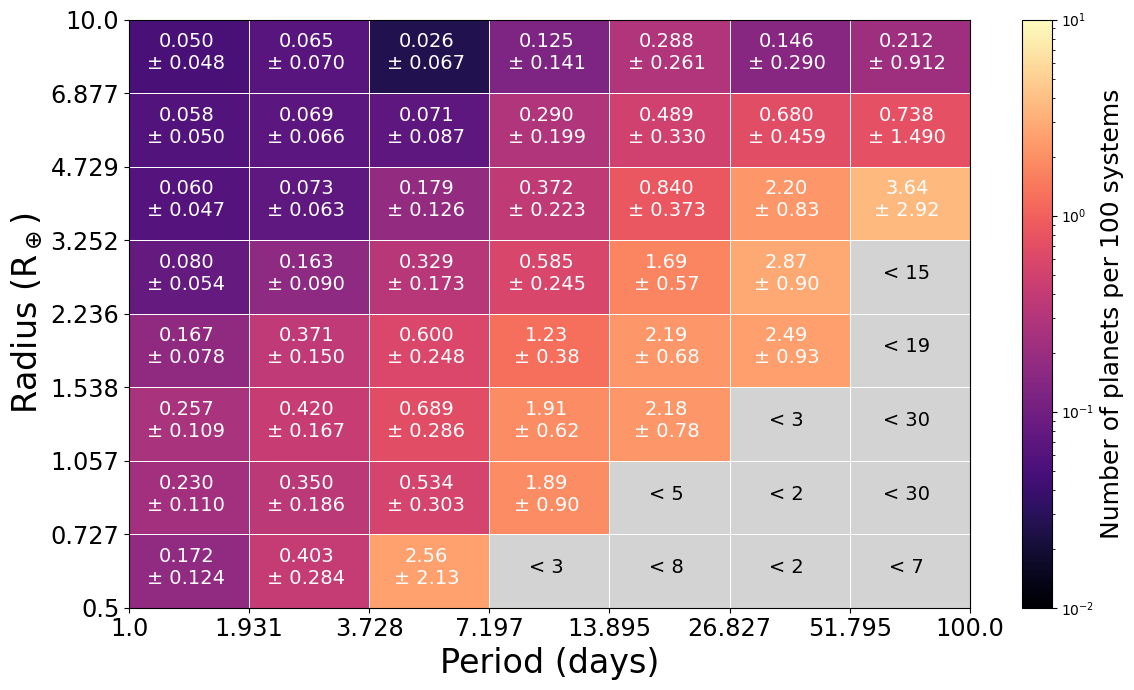

In [30]:
# make a nice plot!
fig, ax = plt.subplots(num=4, figsize=(12, 7))
hatch = plt.fill_between([np.log10(1),np.log10(100)], 
                         np.log10(0.5), np.log10(10), color="lightgray")

im = ax.pcolormesh(np.log10(mp_grid), np.log10(mr_grid), boot_kde_smol_FGK_nan*100, 
                   cmap='magma', norm=matplotlib.colors.LogNorm(vmin=1e-2, vmax=10), shading='flat',
                   edgecolor='white', linewidth=0.5)

for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        if boot_kde_smol_FGK.T[i,j]*100>=1:
            o = '%.2f' % (boot_kde_smol_FGK*100).T[i,j]
            e = '%.2f' % (boot_kde_smol_err_FGK*100).T[i,j]
            t =  o + "\n± " + e
        else:
            o = '%.3f' % (boot_kde_smol_FGK*100).T[i,j]
            e = '%.3f' % (boot_kde_smol_err_FGK*100).T[i,j]
            t =  o + "\n± " + e
        if np.isnan(H_nan_FGK.T[i,j]):
            o = '%.0f' %((boot_kde_smol_FGK*100).T[i,j]+(boot_kde_smol_err_FGK*100).T[i,j])
            ax.text(np.log10(mp_c[j])-0.03, np.log10(mr_c[i]), "< "+str(o), 
                color="k", ha="center", va="center", fontsize=14)
        elif H_lim_FGK.T[i,j]:
            o = '%.0f' %((boot_kde_smol_FGK*100).T[i,j]+(boot_kde_smol_err_FGK*100).T[i,j])
            ax.text(np.log10(mp_c[j])-0.03, np.log10(mr_c[i]), "< "+str(o), 
                color="k", ha="center", va="center", fontsize=14)
        elif boot_kde_smol_FGK.T[i,j]>=0.045:
            ax.text(np.log10(mp_c[j])-0.03, np.log10(mr_c[i]), t, 
                color="k", ha="center", va="center", fontsize=14)
        else:
            ax.text(np.log10(mp_c[j])-0.03, np.log10(mr_c[i]), t, 
                color="white", ha="center", va="center", fontsize=14)

ax.tick_params(axis='both', labelsize='xx-large')
cb = plt.colorbar(im)
cb.set_label(label="Number of planets per 100 systems", fontsize=18)

plt.xlim(np.log10(1.), np.log10(100.))
plt.ylim(np.log10(0.5), np.log10(10.))

plt.xlabel("Period (days)", fontsize=24)
plt.ylabel(r"Radius (R$_\oplus$)", fontsize=24)
plt.xticks(np.log10(mp), labels=[*np.round(np.logspace(np.log10(1), np.log10(100), 8), 3)])
# plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.yticks(np.log10(mr), labels=[*np.round(np.logspace(np.log10(0.5), np.log10(10), 9), 3)])
plt.minorticks_off()
plt.tight_layout()
# plt.show()
plt.savefig('occurrence_map.pdf')

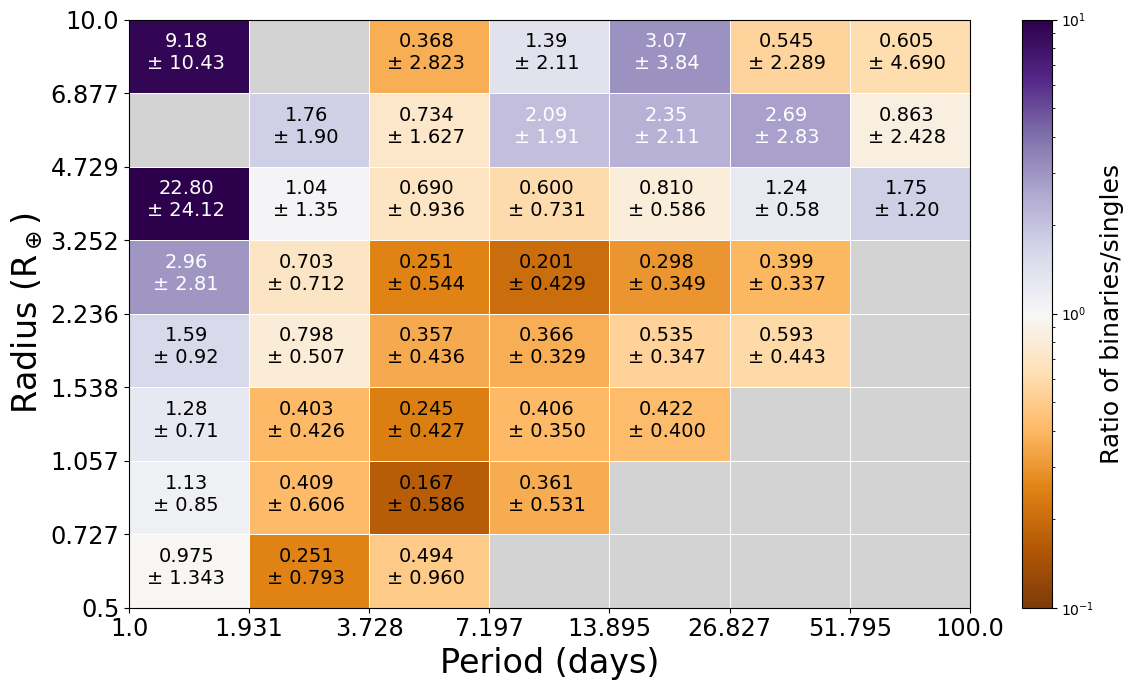

In [31]:
a = np.loadtxt("2d-comp-binary.csv", delimiter=',').reshape(7,8,2)
occ_single = a[:,:,0]
err_single = a[:,:,1]

ratio = boot_kde_smol_FGK/occ_single

ratio_nan = ratio.copy()
ratio_nan[H_FGK < 1] = np.nan
ratio_nan[H_lim_FGK >= 1] = np.nan

ratio_err = np.sqrt(((boot_kde_smol_err_FGK**2)/boot_kde_smol_FGK**2)) + ((err_single**2)/(occ_single**2)) * ratio

# binaries/singles so >1 means more binaries, <1 means more singles

# make a nice plot!
fig, ax = plt.subplots(num=4, figsize=(12, 7))
hatch = plt.fill_between([np.log10(1),np.log10(100)], 
                         np.log10(0.5), np.log10(10), color="lightgray")

im = ax.pcolormesh(np.log10(mp_grid), np.log10(mr_grid), ratio_nan, 
                   cmap='PuOr', norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=10), shading='flat',
                   edgecolor='white', linewidth=0.5)

for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
#         print(float(ratio.T[i, j]))
        if len(str(ratio.T[i, j])) == 3:
            t = ''
        elif ratio.T[i,j]>=1:
            o = '%.2f' % (ratio).T[i,j]
            e = '%.2f' % (ratio_err).T[i,j]
            t =  o + "\n± " + e
        else:
            o = '%.3f' % (ratio).T[i,j]
            e = '%.3f' % (ratio_err).T[i,j]
            t =  o + "\n± " + e
        if np.isnan(H_nan_FGK.T[i,j]):
            pass;
        elif H_lim_FGK.T[i,j]:
            pass;
        elif ratio.T[i,j]<= 2:
            ax.text(np.log10(mp_c[j])-0.03, np.log10(mr_c[i]), t, 
                color="k", ha="center", va="center", fontsize=14)
        else:
            ax.text(np.log10(mp_c[j])-0.03, np.log10(mr_c[i]), t, 
                color="white", ha="center", va="center", fontsize=14)

ax.tick_params(axis='both', labelsize='xx-large')
cb = plt.colorbar(im)
cb.set_label(label="Ratio of binaries/singles", fontsize=18)

plt.xlim(np.log10(1.), np.log10(100.))
plt.ylim(np.log10(0.5), np.log10(10.))

plt.xlabel("Period (days)", fontsize=24)
plt.ylabel(r"Radius (R$_\oplus$)", fontsize=24)
plt.xticks(np.log10(mp), labels=[*np.round(np.logspace(np.log10(1), np.log10(100), 8), 3)])
# plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.yticks(np.log10(mr), labels=[*np.round(np.logspace(np.log10(0.5), np.log10(10), 9), 3)])
plt.minorticks_off()
plt.tight_layout()
# plt.show()
plt.savefig('ratio_map.pdf')


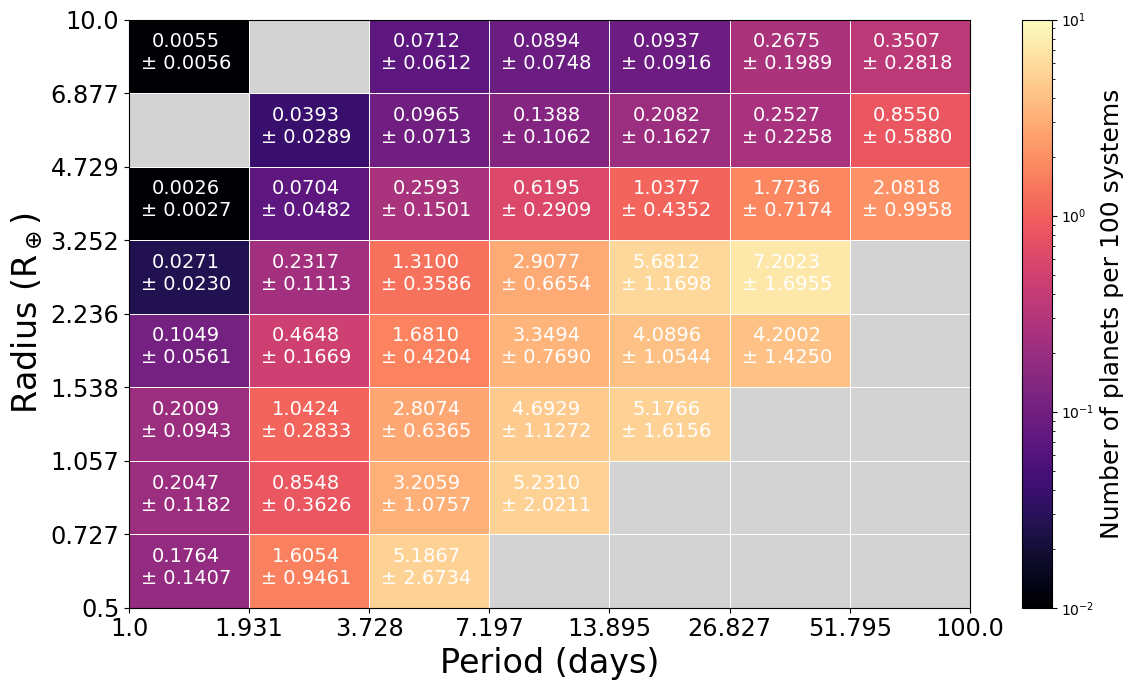

In [32]:
a = np.loadtxt("2d-comp-binary.csv", delimiter=',').reshape(7,8,2)
occ_single = a[:,:,0]
err_single = a[:,:,1]

ratio = occ_single

ratio_nan = ratio.copy()
ratio_nan[H_FGK < 1] = np.nan
ratio_nan[H_lim_FGK >= 1] = np.nan

ratio_err = err_single #np.sqrt(((boot_kde_smol_err_FGK**2)/boot_kde_smol_FGK**2)) + ((err_single**2)/(occ_single**2)) * ratio

# binaries/singles so >1 means more binaries, <1 means more singles

# make a nice plot!
fig, ax = plt.subplots(num=4, figsize=(12, 7))
hatch = plt.fill_between([np.log10(1),np.log10(100)], 
                         np.log10(0.5), np.log10(10), color="lightgray")

im = ax.pcolormesh(np.log10(mp_grid), np.log10(mr_grid), ratio_nan*100, 
                   cmap='magma', norm=matplotlib.colors.LogNorm(vmin=1e-2, vmax=10), shading='flat',
                   edgecolor='white', linewidth=0.5)

for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        if len(str(ratio.T[i, j])) == 3:
            t = ''
        elif ratio.T[i,j]>=1:
            o = '%.3f' % (ratio * 100).T[i,j]
            e = '%.3f' % (ratio_err * 100).T[i,j]
            t =  o + "\n± " + e
        else:
            o = '%.4f' % (ratio * 100).T[i,j]
            e = '%.4f' % (ratio_err * 100).T[i,j]
            t =  o + "\n± " + e
        if np.isnan(H_nan_FGK.T[i,j]):
            pass;
        elif H_lim_FGK.T[i,j]:
            pass;
        elif ratio.T[i,j]>= 2:
            ax.text(np.log10(mp_c[j])-0.03, np.log10(mr_c[i]), t, 
                color="k", ha="center", va="center", fontsize=14)
        else:
            ax.text(np.log10(mp_c[j])-0.03, np.log10(mr_c[i]), t, 
                color="white", ha="center", va="center", fontsize=14)

ax.tick_params(axis='both', labelsize='xx-large')
cb = plt.colorbar(im)
cb.set_label(label="Number of planets per 100 systems", fontsize=18)

plt.xlim(np.log10(1.), np.log10(100.))
plt.ylim(np.log10(0.5), np.log10(10.))

plt.xlabel("Period (days)", fontsize=24)
plt.ylabel(r"Radius (R$_\oplus$)", fontsize=24)
plt.xticks(np.log10(mp), labels=[*np.round(np.logspace(np.log10(1), np.log10(100), 8), 3)])
# plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.yticks(np.log10(mr), labels=[*np.round(np.logspace(np.log10(0.5), np.log10(10), 9), 3)])
plt.minorticks_off()
plt.tight_layout()
# plt.show()
plt.savefig('single_map.pdf')

In [38]:
occ[np.where(complete.T <= 1e-3)] = np.nan

se_z = kde_anywhere(occ, 1, 100, 1, 1.7)
se_occ = np.nansum(se_z)*(np.diff(x)[0]*np.diff(y)[0])
z_se = np.nansum(kde_anywhere(occ_err, 1, 100, 1, 1.7))/np.nansum(
                    kde_anywhere(occ, 1, 100, 1, 1.7))
        
err_se = np.sqrt(z_se**2)*se_occ


sn_z = kde_anywhere(occ, 1, 100, 2.2, 3.5)
sn_occ = np.nansum(sn_z)*(np.diff(x)[0]*np.diff(y)[0])
z_sn = np.nansum(kde_anywhere(occ_err, 1, 100, 2.2, 3.5))/np.nansum(
                    kde_anywhere(occ, 1, 100, 2.2, 3.5))
        
err_sn = np.sqrt(z_sn**2)*sn_occ

# err_sn_se = np.sqrt((z_se)**2 + (z_sn)**2) * (se_occ/sn_occ)

err_sn_se = np.sqrt((err_se)**2 + (err_sn)**2)


print('per 100 stars; super-earth: {:.2f} +/- {:.2f}'.format(se_occ*100, err_se*100))
print('sub-Neptune: {:.2f} +/- {:.2f}'.format(sn_occ*100, err_sn*100))
print('ratio: {:.2f} +/- {:.2f}'.format(se_occ/sn_occ, err_sn_se))

boot_kde_smol_FGK[H_FGK < 1] = np.nan
boot_kde_smol_FGK[H_lim_FGK >= 1] = np.nan

boot_kde_smol_err_FGK[H_FGK < 1] = np.nan
boot_kde_smol_err_FGK[H_lim_FGK >= 1] = np.nan

all_occ = np.nansum(boot_kde_smol_FGK) 
err_all = np.sqrt(np.nansum(boot_kde_smol_err_FGK**2)) * all_occ 

print('per 100 stars; all binaries: {:.2f} +/- {:.2f}'.format(all_occ*100, err_all*100))

a = np.loadtxt("2d-comp-binary.csv", delimiter=',').reshape(7,8,2)
occ_single = a[:,:,0]
err_single = a[:,:,1]

occ_single[H_FGK < 1] = np.nan
occ_single[H_lim_FGK >= 1] = np.nan

err_single[H_FGK < 1] = np.nan
err_single[H_lim_FGK >= 1] = np.nan

os = np.nansum(occ_single)
es = np.sqrt(np.nansum(err_single**2)) * os

print('per 100 stars; all singles: {:.2f} +/- {:.2f}'.format(os*100, es*100))



per 100 stars; super-earth: 30.65 +/- 24.72
sub-Neptune: 16.97 +/- 9.61
ratio: 1.81 +/- 0.27
per 100 stars; all binaries: 35.03 +/- 1.66
per 100 stars; all singles: 69.95 +/- 3.77


In [ ]:
single_rad, single_err = np.loadtxt('50d-radius.csv', delimiter = ',').T

In [ ]:
occ_rad_bins = np.array([1.0, 1.1, 1.21, 1.35, 1.49, 1.64, 1.81, 2.0, 2.21, 2.44, 2.69, 2.97, 3.28, 3.62, 4.0])#
occ_result = []
occ_result_err = []

occ_err_spread = np.ones((100, len(occ_rad_bins)-1, ))

all_occ_single = np.nansum(single_rad)
all_occ_single_err = np.sqrt(np.sum(single_err**2)) * all_occ_single

for n in range(len(occ_rad_bins)-1):
    x = np.linspace(np.log10(1), np.log10(100), num=501)
    y = np.linspace(np.log10(0.5), np.log10(10), num=501)
    
    se_z = kde_anywhere(occ, 1, 50, occ_rad_bins[n], occ_rad_bins[n+1])
    se_occ = np.nansum(se_z)*(np.diff(x)[0] * np.diff(y)[0])
    z_se = np.nansum(kde_anywhere(occ_err, 1, 50, occ_rad_bins[n], occ_rad_bins[n+1]))/np.nansum(
                    kde_anywhere(occ, 1.1, 50, occ_rad_bins[n], occ_rad_bins[n+1]))
        
    err_se = np.sqrt(z_se**2)*se_occ
    
    occ_result.append(se_occ); occ_result_err.append(err_se)

    for k in range(len(occ_err_spread)):
        se_z = kde_anywhere(occurrence[k], 1, 50, occ_rad_bins[n], occ_rad_bins[n+1])
        se_occ = np.nansum(se_z)*(np.diff(x)[0] * np.diff(y)[0])
        
        occ_err_spread[k,n] = se_occ
    
bin_centers = [10**np.mean([np.log10(occ_rad_bins[n]), np.log10(occ_rad_bins[n+1])]) for n in range(len(occ_rad_bins[:-1]))]

occ_result = np.array(occ_result)
occ_result_err = np.array(occ_result_err)
bin_centers = np.array(bin_centers)

all_occ_rad_bin = np.nansum(occ_result)
all_occ_rad_bin_err = np.sqrt(np.sum(occ_result_err**2)) * all_occ_rad_bin


fig, ax = plt.subplots(figsize= (9, 6))
for l in range(100):
    ax.stairs(values = occ_err_spread[l,:], edges = occ_rad_bins, color = 'r', linewidth = 0.1, alpha = 0.25)
ax.errorbar(bin_centers, occ_result, yerr = occ_result_err, color = 'r', linestyle = '')
ax.stairs(values = occ_result, edges = occ_rad_bins, color = 'r', linewidth = 2, label = 'binaries')
ax.stairs(values = single_rad, edges = occ_rad_bins, color = 'k', linewidth = 2, label = 'singles')
ax.errorbar(bin_centers, single_rad, yerr = single_err, color = 'k', linestyle = '')
ax.set_xlim(1, 4)
# ax.set_ylim(-0.001, 0.074)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_ylabel('Occurrence within 1-50 d [per system]', fontsize = 20)
ax.set_xlabel(r'R$_{\rm p}$ [R$_{\oplus}$]', fontsize = 20)
ax.legend(loc = 'best', fontsize = 20, framealpha = 0)
plt.minorticks_on()
ax.tick_params(which='minor', bottom=True, top =False, left=True, right=False)
ax.tick_params(bottom=True, top =False, left=True, right=False)
ax.tick_params(which='both', labelsize = 'xx-large', direction='in')
ax.tick_params('both', length=10, width=2.5, which='major')
ax.tick_params('both', length=6, width=1.5, which='minor')
plt.tight_layout()
plt.savefig('occ_rgap_single.pdf', dpi = 400)

In [ ]:
ks_alpha = ks_2samp(single_rad, occ_result).pvalue
ks_zscore = norm.ppf(1 - ks_alpha/2)
print('ks zscore:', ks_zscore)
print('ks p-value:', ks_alpha)

ad_alpha = anderson_ksamp(np.array([single_rad, occ_result], dtype = 'object'))[-1]
ad_zscore = norm.ppf(1 - ad_alpha/2)
print('ad zscore:', ad_zscore)

In [ ]:
print("occurrence per 100 stars between 1-50d, 1-4 Rearth, binaries: {:.3f} +/- {:.3f}".format(all_occ_rad_bin, all_occ_rad_bin_err))
print('occurrence per 100 stars between 1-50d, 1-4 Rearth, singles: {:.3f} +/- {:.3f}'.format(all_occ_single, all_occ_single_err))
print('relative number of planets in singles vs binaries: {:.2f} times more in singles'\
      .format(all_occ_single/all_occ_rad_bin))
print('OR relative number of planets in singles vs binaries: {:.2f} times more in binaries'\
      .format(all_occ_rad_bin/all_occ_single))


# Make a nice MOLUSC plot for the paper

In [ ]:
from astropy.table import Table, join

In [ ]:
molusc_file = Table.read('/Users/ksullivan/Research/kep_occurrence/2086403376201149184_samples.txt', format = 'ascii')

In [ ]:
molusc_file

In [ ]:
fig, ax = plt.subplots()

a = ax.scatter(molusc_file['col1'][np.where((molusc_file['col8'] > 0.75 * 1.61) & (molusc_file['col8'] < 1.25 * 1.61))] , molusc_file['col0'][np.where((molusc_file['col8'] > 0.75 * 1.61) & (molusc_file['col8'] < 1.25 * 1.61))] , s = 3, color = 'k', rasterized = True)
ax.set_xscale('log')
ax.set_ylabel('Mass Ratio', fontsize = 15)
ax.set_xlabel('Projected Separation [AU]', fontsize = 15)
plt.minorticks_on()
ax.tick_params(which = 'both', bottom=True, top = False, left=True, right=False)
ax.tick_params(which='both', labelsize = 14, direction='in')
ax.tick_params('both', length=8, width=1.5, which='major')
ax.tick_params('both', length=4, width=1, which='minor')
ax.set_xlim(0.7, 250)
ax.set_ylim(-0.05, 1.05)
plt.tight_layout()
plt.savefig('MOLUSC_truncated_output_RUWE_filter.pdf')

In [ ]:
fig, ax = plt.subplots()

a = ax.scatter(molusc_file['col1'] , molusc_file['col0'] , s = 3, color = 'k', rasterized = True)
ax.set_xscale('log')
ax.set_ylabel('Mass Ratio', fontsize = 15)
ax.set_xlabel('Projected Separation [AU]', fontsize = 15)
plt.minorticks_on()
ax.tick_params(which = 'both', bottom=True, top = False, left=True, right=False)
ax.tick_params(which='both', labelsize = 14, direction='in')
ax.tick_params('both', length=8, width=1.5, which='major')
ax.tick_params('both', length=4, width=1, which='minor')
ax.set_xlim(0.7, 250)
ax.set_ylim(-0.05, 1.05)
plt.tight_layout()
plt.savefig('MOLUSC_truncated_output.pdf')

# Check the CDPP slope for the singles versus the binaries

In [ ]:
koi_sample = Table.read('../../big_cat.fits')
single_koi_sample = Table.read('../../bergerCatalog/dr25_FGK_PCs_B20_ruwe.csv', format = 'ascii.csv')
kepdata = Table.read('../stellarCatalogs-singles/dr25_stellar_supp_gaia_clean_all.txt', format = 'ascii.csv')

In [ ]:
koi_sample['kepid'] = [int(koi_sample[n]['kepid']) for n in range(len(koi_sample))]
single_koi_sample['kepid'] = [int(single_koi_sample[n]['kepid_x']) for n in range(len(single_koi_sample))]

In [ ]:
kepdata_bin = Table(kepdata[0], names = kepdata.keys())

for n, koi in enumerate(koi_sample):
    row = kepdata[np.where(int(koi['kepid']) == kepdata['kepid'])]
    if len(row):
        kepdata_bin.add_row(row[0])
    else:
        pass;
kepdata_bin.remove_row(0)

kepdata_single = Table(kepdata[0], names = kepdata.keys())
for n, koi in enumerate(single_koi_sample):
    try:
        row = kepdata[np.where(int(koi['kepid_x']) == kepdata['kepid'])]
        kepdata_single.add_row(row[0])
    except:
        pass;
kepdata_single.remove_row(0)

In [ ]:
print(len(kepdata_bin), len(kepdata_single))

In [ ]:
bins = np.linspace(-0.8, 0.5, 25)

fig, ax = plt.subplots()
ax.hist(kepdata_bin['cdppslplong'], bins = bins, histtype = 'step', color = 'r', linewidth = 2, label = 'binary CDPP slope long')
ax.hist(kepdata_bin['cdppslpshrt'], bins = bins, histtype = 'step', color = 'r', linestyle = '--', linewidth = 2, label = 'binary CDPP slope short')
ax.hist(kepdata_single['cdppslplong'], bins = bins, histtype = 'step', color = 'k', linewidth = 2, label = 'single CDPP slope long')
ax.hist(kepdata_single['cdppslpshrt'], bins = bins, histtype = 'step', color = 'k', linestyle = '--', linewidth = 2, label = 'single CDPP slope short')
ax.legend(loc = 'best', fontsize = 14, framealpha = 0)
ax.set_ylabel('N', fontsize = 18)
ax.set_xlabel('CDPP slope', fontsize = 18)
ax.set_xlim(-0.8, 0.5)
plt.minorticks_on()
ax.tick_params(which = 'both', bottom=True, top = False, left=True, right=False)
ax.tick_params(which='both', labelsize = 'x-large', direction='in')
ax.tick_params('both', length=10, width=2, which='major')
ax.tick_params('both', length=5, width=1.5, which='minor')
plt.tight_layout()
plt.savefig('cdpp_slope_compare.pdf')

print('long p-value, K-S', ks_2samp(kepdata_bin['cdppslplong'],kepdata_single['cdppslplong']).pvalue)
print('short p-value, K-S', ks_2samp(kepdata_bin['cdppslpshrt'],kepdata_single['cdppslpshrt']).pvalue)

In [ ]:
koidata = Table.read('kep_cumulative.csv', format = 'ascii.csv')

In [ ]:
koidata

In [ ]:
koidata_bin = Table(koidata[0], names = koidata.keys())

for n, koi in enumerate(koi_sample):
    row = koidata[np.where(int(koi['kepid']) == koidata['kepid'])]
    for r in row:
        if len(r):
            if r['koi_disposition'] != 'FALSE POSITIVE':
                koidata_bin.add_row(r)
    else:
        pass;
koidata_bin.remove_row(0)

koidata_single = Table(koidata[0], names = koidata.keys())
for n, koi in enumerate(single_koi_sample):
    row = koidata[np.where(int(koi['kepid']) == koidata['kepid'])]
    for r in row:
        if len(r):
            if r['koi_disposition'] != 'FALSE POSITIVE':
                koidata_single.add_row(r)
    else:
        pass;
koidata_single.remove_row(0)

In [ ]:
bins = np.linspace(0, 1, 20)

fig, ax = plt.subplots()
ax.hist(koidata_single['koi_score'], color = 'orange', linewidth = 2, alpha = 0.5, label = 'single planet score', cumulative = True, density = True)
ax.hist(koidata_bin['koi_score'], histtype = 'step', color = 'purple', linewidth = 2, label = 'binary planet score', cumulative = True, density = True)
ax.legend(loc = 'upper left', fontsize = 14, framealpha= 0)
ax.set_ylabel('Cumulative probability', fontsize = 18)
ax.set_xlabel('Planet vetting score', fontsize = 18)
# ax.set_xlim(-0.8, 0.5)
# ax.set_yscale('log')
plt.minorticks_on()
ax.tick_params(which = 'both', bottom=True, top = False, left=True, right=False)
ax.tick_params(which='both', labelsize = 'x-large', direction='in')
ax.tick_params('both', length=10, width=2, which='major')
ax.tick_params('both', length=5, width=1.5, which='minor')
plt.tight_layout()
plt.savefig('vetting_score_comp.pdf')

print('vetting score p-value, K-S', ks_2samp(koidata_bin['koi_score'],koidata_single['koi_score']).pvalue)


In [ ]:
with open('bigCat_table.tex', 'w') as f:
    f.write('\\tablehead{\colhead{Gaia DR2} & \colhead{Kepler ID} & \colhead{distance} \
    & \colhead{separation} \
    & \colhead{M$_{\\rm pri}$} \
    & \colhead{Mass ratio} \
    & \colhead{$T_{\\rm eff, pri}$} \
    & \colhead{$L_{\\rm pri}$}\
    & \colhead{$T_{\\rm eff, sec}$}\
    & \colhead{$L_{\\rm sec}$}\
    & \colhead{PRCF$_{\\rm pri}$}\
    & \colhead{PRCF$_{\\rm sec}$}\\\\\
    \colhead{} & \colhead{} & \colhead{pc} \
    & \colhead{au} \
    & \colhead{M$_{\\odot}$} \
    & \colhead{} \
    & \colhead{K} \
    & \colhead{$L_{\\odot}$}\
    & \colhead{K}\
    & \colhead{$L_{\\odot}$}\
    & \colhead{}\
    & \colhead{}}')
    for line in koi_sample:
        f.write('{:.0f} & {:.0f} & {:.0f} & {:.0f}$^{{+{:.0f}}}_{{-{:.0f}}}$ & {:.2f}$^{{+{:.2f}}}_{{-{:.2f}}}$ &\
        {:.2f}$^{{+{:.2f}}}_{{-{:.2f}}}$ & {:.0f}$^{{+{:.0f}}}_{{-{:.0f}}}$ & {:.2f}$^{{+{:.2f}}}_{{-{:.2f}}}$ &\
        {:.0f}$^{{+{:.0f}}}_{{-{:.0f}}}$ & {:.2f}$^{{+{:.2f}}}_{{-{:.2f}}}$ & {:.2f}$^{{+{:.2f}}}_{{-{:.2f}}}$ & {:.2f}$^{{+{:.2f}}}_{{-{:.2f}}}$\\\ \n'\
                .format(line['Gaia DR2'], line['kepid'], line['dist'],\
                        line['rho'], line['e_rho'], line['E_rho'], \
                        line['m1'], line['e_m1'], line['E_m1'], \
                       line['q'], line['e_q'], line['E_q'],\
                       line['t1'], line['e_t1'], line['E_t1'],\
                       line['l1'], line['e_l1'], line['E_l1'],\
                       line['t2'], line['e_t2'], line['E_t2'],\
                       line['l2'], line['e_l2'], line['E_l2'],\
                        line['prcf1'], line['e_prcf1'], line['E_prcf1'],\
                        line['prcf2'], line['e_prcf2'], line['E_prcf2']))